##### Copyright 2024 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Gemini API - read a PDF

This notebook demonstrates how you can convert a PDF file so that it can be read by the Gemini API.

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/PDF_Files.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

## Setup

In [1]:
!pip install -Uq google-generativeai

In [2]:
import google.generativeai as genai


import pathlib
import tqdm
import os

In [3]:
from google.colab import userdata
genai.configure(api_key=userdata.get("GOOGLE_API_KEY"))

Install the PDF processing tools:

In [4]:
!apt install poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.4 [186 kB]
Fetched 186 kB in 0s (1,059 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 123589 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.4_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.4) ...
Setting up poppler-utils (22.02.0-2ubuntu0.4) ...
Processing triggers for man-db (2.10.2-1) ...


## Download and inspect the PDF

This textbook is from OpenStax, it's License is Commons Attribution License v4.0. More detrails are [available on the site](https://openstax.org/details/books/university-physics-volume-2).

In [5]:
import pathlib

In [37]:
if not pathlib.Path('test.pdf').exists():
  !curl -o test.pdf https://storage.googleapis.com/cloud-samples-data/generative-ai/pdf/2403.05530.pdf

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7059k  100 7059k    0     0  35.4M      0 --:--:-- --:--:-- --:--:-- 35.5M


Look at one of the pages:

In [66]:
!pdftoppm test.pdf -f 1 -l 20 page-image -jpeg
!ls

Ch3-121.pdf  Ch3-131.pdf  Ch3-141.pdf  Ch3-151.pdf	       page-image-04.jpg  page-image-14.jpg
Ch3-122.pdf  Ch3-132.pdf  Ch3-142.pdf  Ch3-152.pdf	       page-image-05.jpg  page-image-15.jpg
Ch3-123.pdf  Ch3-133.pdf  Ch3-143.pdf  Ch3-153.pdf	       page-image-06.jpg  page-image-16.jpg
Ch3-124.pdf  Ch3-134.pdf  Ch3-144.pdf  Ch3-154.pdf	       page-image-07.jpg  page-image-17.jpg
Ch3-125.pdf  Ch3-135.pdf  Ch3-145.pdf  images-001.jpg	       page-image-08.jpg  page-image-18.jpg
Ch3-126.pdf  Ch3-136.pdf  Ch3-146.pdf  page-image-001.jpg      page-image-09.jpg  page-image-19.jpg
Ch3-127.pdf  Ch3-137.pdf  Ch3-147.pdf  page-image-01.jpg       page-image-10.jpg  page-image-20.jpg
Ch3-128.pdf  Ch3-138.pdf  Ch3-148.pdf  page-image-02.jpg       page-image-11.jpg  sample_data
Ch3-129.pdf  Ch3-139.pdf  Ch3-149.pdf  page-image-%03d-01.jpg  page-image-12.jpg  test.pdf
Ch3-130.pdf  Ch3-140.pdf  Ch3-150.pdf  page-image-03.jpg       page-image-13.jpg  test.png


In [39]:
import PIL.Image

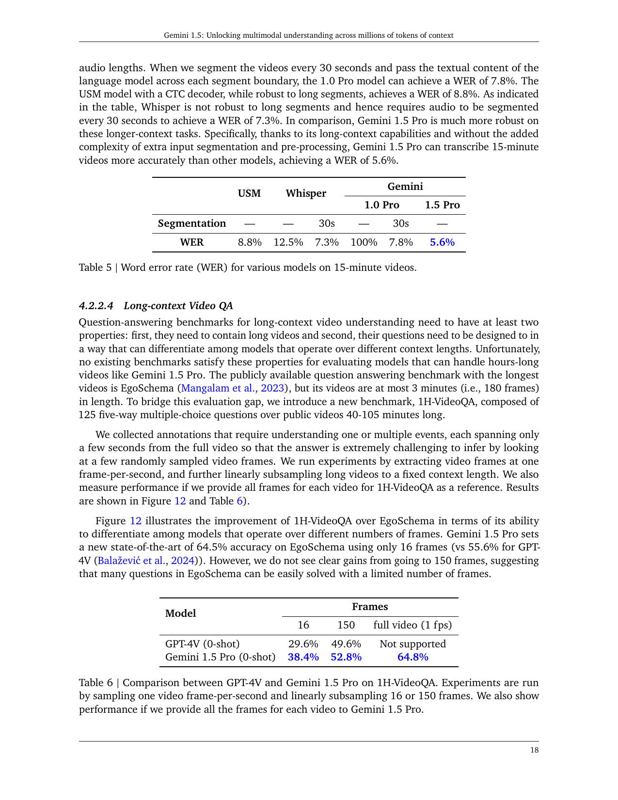

In [76]:
img = PIL.Image.open(f"page-image-18.jpg")
img.thumbnail([800, 800])
img

## Upload the file to the API

In [41]:
file_ref = genai.upload_file('test.pdf')

## Try it out

In [42]:
model = genai.GenerativeModel(model_name='gemini-1.5-flash')

In [48]:
model.count_tokens([file_ref, "Can you summarize this file for me?"])

total_tokens: 8

In [53]:
response = model.generate_content(
    [file_ref, '\n\nCan you summarize this file as a bulleted list?']
)

In [54]:
from IPython.display import Markdown
Markdown(response.text)

Sure, here is a bulleted list summarizing the file:

- **Gemini 1.5 Pro: Unlocking Multimodal Understanding Across Millions of Tokens of Context** is a research report on the latest model of the Gemini family, Gemini 1.5 Pro. 
- Gemini 1.5 Pro is a highly compute-efficient multimodal mixture-of-experts model that can recall and reason over fine-grained information from millions of tokens of context, including multiple long documents and hours of video and audio.
- Gemini 1.5 Pro achieves near-perfect recall on long-context retrieval tasks across modalities, improves the state-of-the-art in long-document QA, long-video QA and long-context ASR, and matches or surpasses Gemini 1.0 Ultra's state-of-the-art performance across a broad set of benchmarks.
- Gemini 1.5 Pro is built to handle extremely long contexts, up to at least 10M tokens, enabling the processing of long-form mixed-modality inputs, including entire collections of documents, multiple hours of video, and almost five days long of audio.
- Gemini 1.5 Pro surpasses Gemini 1.0 Pro and performs at a similar level to 1.0 Ultra on a wide array of benchmarks while requiring significantly less compute to train.
- Gemini 1.5 Pro greatly surpasses Gemini 1.0 Pro, performing better on the vast majority of benchmarks (i.e., 29/33), increasing the margin in particular for Math, Science and Reasoning (+38.4%), Multilinguality (+22.3%), Video Understanding (+16.9%), Image Understanding (+6.5%), and Code (+8.9%). 
- However, a more striking comparison is the one with Gemini 1.0 Ultra, a state-of-the-art model across many capabilities. Despite Gemini 1.5 Pro using significantly less training compute and being more efficient to serve, we find Gemini 1.5 Pro to perform better on more than half of the benchmarks (19/33), in particular on text (12/15) and many of the vision benchmarks (6/13).
- The report provides an overview of the model architecture and presents the results of large-scale quantitative evaluations comparing Gemini 1.5 Pro to other LLMs. 
- It also discusses the responsible deployment process, including the process for impact assessment, developing model policies, evaluations, and mitigations of harm before deployment decisions. 
- The report concludes with a discussion of the future of long-context multimodal AI and calls for the development of new benchmarks and evaluation methodologies to drive progress in the field.

In [75]:
response = model.generate_content(
    [file_ref, '\n\nWhat do the plots on page 8 mean?']
)
Markdown(response.text)

The plots on page 8 show the average negative log-likelihood (NLL) as a function of token position in long documents and code data. A lower value demonstrates better prediction. Gemini 1.5 Pro shows improved predictions up to 1M tokens for long-documents and 10M tokens for code, whereas Gemini 1.0 Pro improves up to only 32K tokens. The NLL follows a power-law trend up until 1M tokens (documents) and 2M tokens (code) with a deviating trend at 10M tokens.